<a href="https://colab.research.google.com/github/jaydenchoe/Fundamentals-of-Deep-Learning-Book/blob/master/ch08_embedding_representation/Ch08_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementing an Autoencoder in PyTorch

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms, utils
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import math

In [2]:
class Encoder(nn.Module):
  def __init__(self, n_in, n_hidden_1, n_hidden_2, n_hidden_3, n_out):
    super(Encoder, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(n_in, n_hidden_1, bias=True),
        nn.BatchNorm1d(n_hidden_1),
        nn.Sigmoid())
    self.layer2 = nn.Sequential(
        nn.Linear(n_hidden_1, n_hidden_2, bias=True),
        nn.BatchNorm1d(n_hidden_2),
        nn.Sigmoid())
    self.layer3 = nn.Sequential(
        nn.Linear(n_hidden_2, n_hidden_3, bias=True),
        nn.BatchNorm1d(n_hidden_3),
        nn.Sigmoid())
    self.layer4 = nn.Sequential(
        nn.Linear(n_hidden_3, n_out, bias=True),
        nn.BatchNorm1d(n_out),
        nn.Sigmoid())

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    return self.layer4(x)

class Decoder(nn.Module):
  def __init__(self, n_in, n_hidden_1, n_hidden_2, n_hidden_3, n_out):
    super(Decoder, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(n_in, n_hidden_1, bias=True),
        nn.BatchNorm1d(n_hidden_1),
        nn.Sigmoid())
    self.layer2 = nn.Sequential(
        nn.Linear(n_hidden_1, n_hidden_2, bias=True),
        nn.BatchNorm1d(n_hidden_2),
        nn.Sigmoid())
    self.layer3 = nn.Sequential(
        nn.Linear(n_hidden_2, n_hidden_3, bias=True),
        nn.BatchNorm1d(n_hidden_3),
        nn.Sigmoid())
    n_size = math.floor(math.sqrt(n_out))
    self.layer4 = nn.Sequential(
        nn.Linear(n_hidden_3, n_out, bias=True),
        nn.BatchNorm1d(n_out),
        nn.Sigmoid(),
        nn.Unflatten(1, torch.Size([1, n_size,n_size])))

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    return self.layer4(x)

encoder = Encoder(784,1000,500,250,2)
decoder = Decoder(2,250,500,1000,784)

In [3]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(),
                       lr = 0.001,
                       betas=(0.9,0.999),
                       eps=1e-08)

In [4]:
trainset = datasets.MNIST('.',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)
trainloader = DataLoader(trainset,
                         batch_size=32,
                         shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.74MB/s]


In [5]:
print(trainset[0][0].shape)

torch.Size([1, 28, 28])


In [6]:
# Training Loop
NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
  for input, labels in trainloader:
    optimizer.zero_grad()
    code = encoder(input)
    output = decoder(code)
    #print(input.shape, output.shape)
    loss = loss_fn(output, input)
    optimizer.step()
  print(f"Epoch: {epoch} Loss: {loss}")

Epoch: 0 Loss: 0.2794044017791748
Epoch: 1 Loss: 0.2802300751209259
Epoch: 2 Loss: 0.276790976524353
Epoch: 3 Loss: 0.27940964698791504
Epoch: 4 Loss: 0.2782300114631653


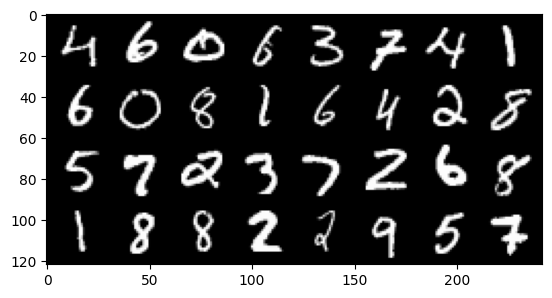

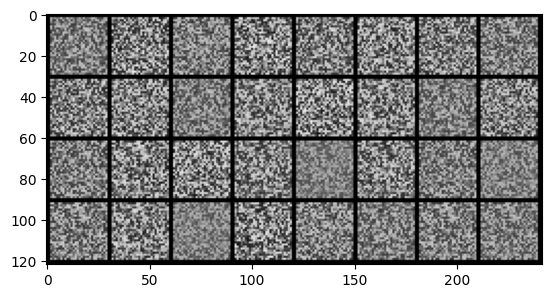

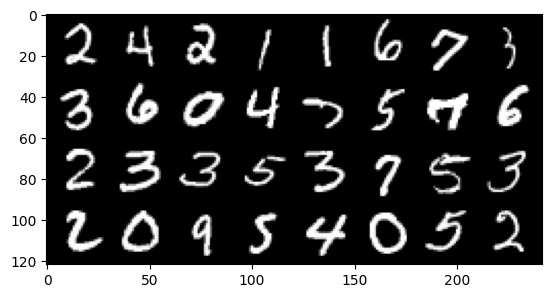

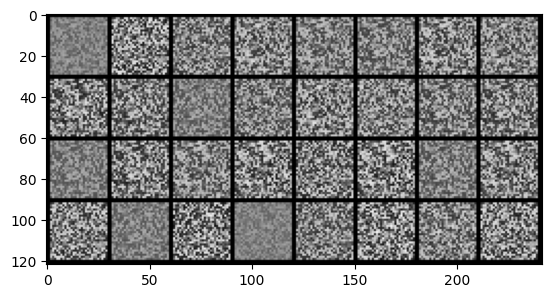

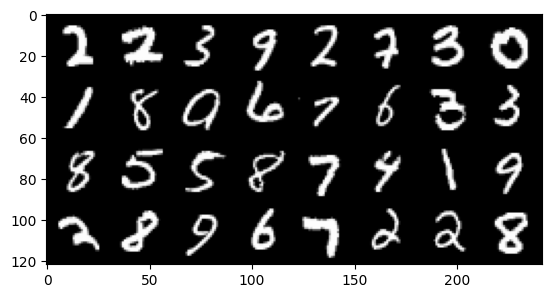

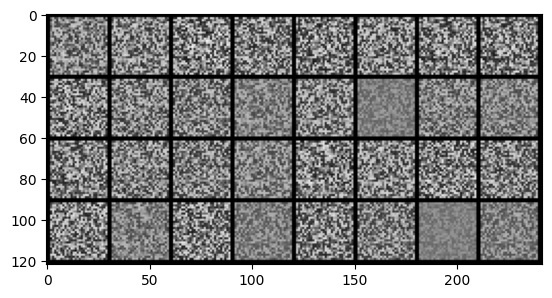

In [7]:
i = 0
with torch.no_grad():
  for images, labels in trainloader:
    if i == 3:
      break
    grid = utils.make_grid(images)
    plt.figure()
    plt.imshow(grid.permute(1,2,0))

    code = encoder(images)
    output = decoder(code)

    grid = utils.make_grid(output)
    plt.figure()
    plt.imshow(grid.permute(1,2,0))
    i += 1

# Denoising to Force Robust Representations

In [8]:
import torch

In [9]:
def corrupt_input(x):
    corrupting_matrix = 2.0*torch.rand_like(x)

    return x * corrupting_matrix

# x = mnist data image of shape 28*28=784
x = torch.rand((28,28))
corrupt = 1.0 # set to 1.0 to corrupt input
c_x = (corrupt_input(x) * corrupt) + (x * (1 - corrupt))

# Implementing the Skip-Gram Architecture

In [10]:
import torch.nn as nn

In [11]:
vocab_size = 500
emb_vector_len = 128

embedding = nn.Embedding(num_embeddings = vocab_size,
                         embedding_dim = emb_vector_len)

In [12]:
!pip install info-nce-pytorch

In [13]:
# We create dummy outputs and targets for illustrative purposes
from info_nce import InfoNCE
outputs = torch.randint(0,100,(100,100))
targets = torch.randint(0,100,(100,100))

In [14]:
# loss_fn = InfoNCE()
# batch_size, embedding_size = 32, 128
# query = embedding(outputs)
# positive_key = embedding(targets)
# output = loss_fn(query, positive_key)

In [15]:
import torch.optim as optim

In [16]:
optimizer = optim.SGD(embedding.parameters(),
                      lr = 0.1)
def train(inputs, targets):
  optimizer.zero_grad()
  input_emb = embedding(inputs)
  target_emb = embedding(targets)
  loss = loss_fn(input_emb, target_emb)
  loss.backward()
  optimizer.step()
  return loss

In [17]:
cosine_similarity = nn.CosineSimilarity()

def evaluate(inputs, targets, embedding):
  with torch.no_grad():
    input_emb = embedding(inputs)
    target_emb = embedding(targets)
    norm = torch.sum(input_emb, dim=1)
    normalized = input_emb/norm
    score = cosine_similarity(normalized, target_emb)
    return normalized, score

In [18]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
# n_epochs = 1
# for epoch in range(n_epochs):
#   # Train
#   running_loss = 0.0
#   for inputs, targets in trainloader:
#     loss = train(inputs, targets)
#     running_loss += loss.item()

#   writer.add_scalar('Train Loss',
#                     running_loss/len(trainloader), epoch)
#   #Validate
#   running_score = 0.0
#   for inputs, targets in valloader:
#     _, score = evaluate(inputs, targets)
#     running_score += score

#   writer.add_scalar('Val Score',
#                     running_score/len(valloader), epoch)